## Esercizi - Interpolazione ed approssimazione

- esempio di interpolazione 2D

- costruiamo un problema malcondizionato per verificare che se si calcola la fattorizzazione QR con il metodo di Gram-Schmidt (GS) la diagonale di R non va sotto a 10^{-8}, mentre con il metodo di Gram-Schmidt Modificato (MGS) si hanno risultati accurati. 

### Interpolazione 2D

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import scipy.interpolate as interp

C:\Users\Andrea\AppData\Local\Temp\ipykernel_10744\1416918470.py:14: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  f = interp.interp2d(X, Y, Z, kind='cubic')
C:\Users\Andrea\AppData\Local\Temp\ipykernel_10744\1416918470.py:18: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scat

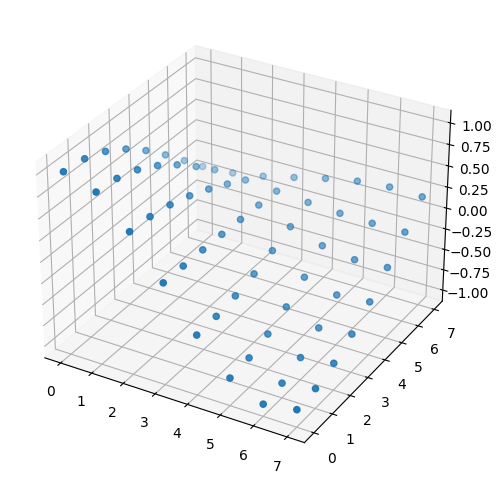

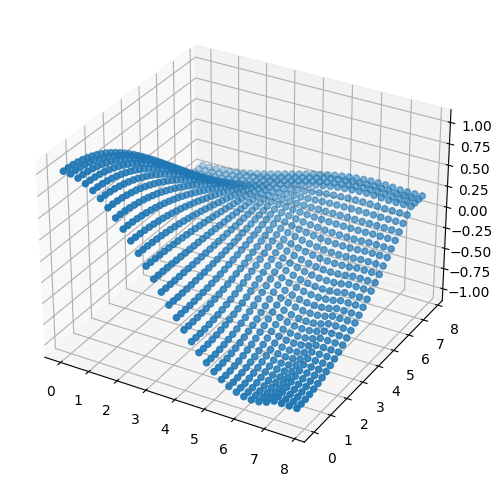

In [25]:
# Vediamo un esempio di interpolazione cubica a tratti in 2D:
Nx = 8
Ny = 8
omega_nu_x = (2*np.pi/Nx) * 0.16*(Nx/2.)
omega_nu_y = (2*np.pi/Ny) * 0.08*(Ny/2.)
X,Y = np.meshgrid(np.arange(Nx),np.arange(Ny))
Z = np.atleast_2d(np.cos(omega_nu_y*np.arange(Ny))).T @ np.atleast_2d(np.cos(omega_nu_x*np.arange(Nx)))
# rappresentazione punti per cui deve passare
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(X.flatten(),Y.flatten(),Z.flatten())

# interpolazione
f = interp.interp2d(X, Y, Z, kind='cubic')
xnew = np.arange(0,Nx,0.25)
ynew = np.arange(0,Ny,0.25)
xx, yy = np.meshgrid(xnew, ynew)
znew = f(xnew,ynew)
# rappresentazione interpolante
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(xx.flatten(),yy.flatten(),znew.flatten())

plt.show()

### Metodi di Gran-Schmidt

Ora vediamo sperimentalmente l'instabilità del metodo di Gram-Schmidt ed il miglioramento ottenuto dal metodo modificato:

In [26]:
n=100
# creo una matrice "A" malcondizionata a partire dalla sua SVD:
[U,X] = np.linalg.qr(np.random.rand(n,n))
[V,X] = np.linalg.qr(np.random.rand(n,n))
Sigma = 2.**np.arange(0,-n,-1)
A = U @ np.diag(Sigma) @ V.T
print ('K(A) = ', Sigma[0]/Sigma[-1], "=> mal condizionata.")

K(A) =  6.338253001141147e+29 => mal condizionata.


Implementiasmo GS e MGS in un'unica funzione:

In [27]:
def all_GS(A,modificato=True):
    m = A.shape[0] 
    n = A.shape[1]  
    Q = np.zeros([m, n])
    R = np.zeros([n, n])
    
    for j in range(0,n):  # itero sulle colonne
      Q[:,j] = A[:,j]
      for i in range(0,j):
        if modificato:
            R[i,j] = Q[:,i].T @ Q[:,j];  # G.S. Modificato
        else:
            R[i,j] = Q[:,i].T @ A[:,j];  # G.S. Classico
        #endif
        Q[:,j] = Q[:,j] - R[i,j]*Q[:,i]
        #print('Q[:,', j, '] = ', Q[:,j])
      #endfor
      R[j,j] = np.linalg.norm(Q[:,j]);     # norma 2
      if  R[j,j]==0:  break;  #endif       # significa che c'e' dipendenza lineare.
      Q[:,j] = Q[:,j] / R[j,j];            # Q ha colonne ortogonali e di norma 2 unitaria, e dunque e' ortonormale
    #endfor                                
    return Q,R

Eseguiamo i due metodi di Gram-Schmidt

In [28]:
Q,R = all_GS(A.copy(),modificato=False) # Classico
Qm,Rm = all_GS(A.copy()) # Modificato

Confrontiamo, su scala logaritmica, i valori singolari con le diagonali di R e Rm:

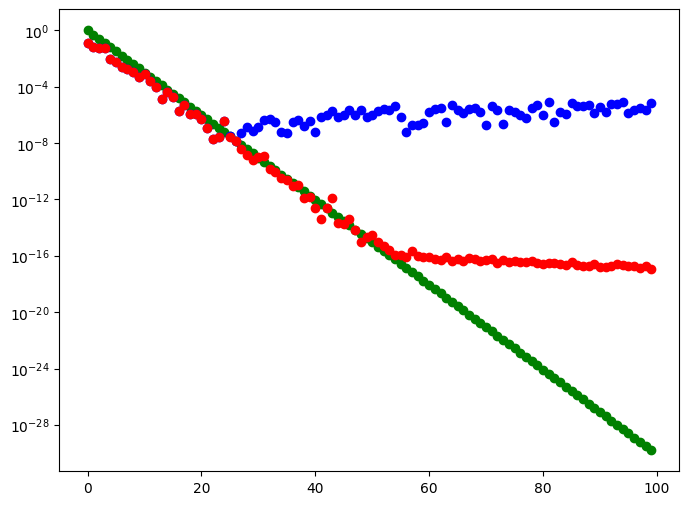


==> I valori sulla diagonale di R sono circa proporzionali ai valori singolari,
 
quindi il metodo di Gram-Schmidt classico (curva blu) non approssima bene le componenti 

singolari meno significative di A e quindi produce in questo caso errori rilevanti 

nell'inversione di matrice richiesta dal problema dei minimi quadrati lineari, mentre
 
il metodo di Gram-Schmidt Modificato li approssima bene fino alla precisione di macchina.
 



In [29]:
plt.figure(figsize=(8,6))
plt.semilogy(Sigma,'go')
plt.semilogy(np.diag(R),'bo')
plt.semilogy(np.diag(Rm),'ro')
plt.show()
print('''
==> I valori sulla diagonale di R sono circa proporzionali ai valori singolari,\n 
quindi il metodo di Gram-Schmidt classico (curva blu) non approssima bene le componenti \n
singolari meno significative di A e quindi produce in questo caso errori rilevanti \n
nell'inversione di matrice richiesta dal problema dei minimi quadrati lineari, mentre\n 
il metodo di Gram-Schmidt Modificato li approssima bene fino alla precisione di macchina.\n 
''')